In [11]:
import pandas as pd
import seaborn as sns

## Plot
1. Plot the horizontal cutoff for training length
2. Test for post > repetition

In [2]:
path = "/Users/xujinliu/projects/cluster_results/long_native_trials/"

dfs = []

for synth_seed in range(1000):
    for model_seed in range(4):
        file_csv = path + f"/{synth_seed}_dinov2-base-imagenet1k-1-layer_seed{model_seed}.csv"
        loaded = pd.read_csv(file_csv)
        loaded["model_seed"] = model_seed
        loaded["synth_seed"] = synth_seed

        dfs.append(loaded)

df = pd.concat(dfs)

In [9]:
# Exclude repetition
df = df[~(df["Image phase"] == "repetition")]
df["Accuracy"] = df["Ground truth class"] == df["Predicted class"]
df["Accuracy"] = df["Accuracy"].astype(int)

In [10]:
df.head()

,Image phase,Time index,Ground truth class,Predicted class,model_seed,synth_seed,Accuracy
0,pre,0,5,33,0,0,0
1,pre,1,743,794,0,0,0
2,pre,2,511,511,0,0,1
3,gray,0,5,5,0,0,1
4,gray,1,743,743,0,0,1


In [21]:
# Lineplot takes too long to plot. Let's pre-calculate the sem for each time index and phase
grouped = df.groupby(["Time index", "Image phase"])['Accuracy'].agg(['mean', 'sem', 'count'])

# Calculate the 95% CI
z = 1.96  # Z-score for 95% CI
grouped['lower_95_ci'] = grouped['mean'] - z * grouped['sem']
grouped['upper_95_ci'] = grouped['mean'] + z * grouped['sem']

grouped = grouped.reset_index()[["Time index", "Image phase", "mean", "lower_95_ci", "upper_95_ci"]]
grouped.head()

,Time index,Image phase,mean,lower_95_ci,upper_95_ci
0,0,gray,0.85400,0.843056,0.864944
1,0,post,0.72875,0.714970,0.742530
2,0,pre,0.56150,0.546121,0.576879
3,1,gray,0.83450,0.822982,0.846018
4,1,post,0.70375,0.689598,0.717902


In [22]:
import matplotlib.pyplot as plt

Text(40, 15, 'Training cutoff')

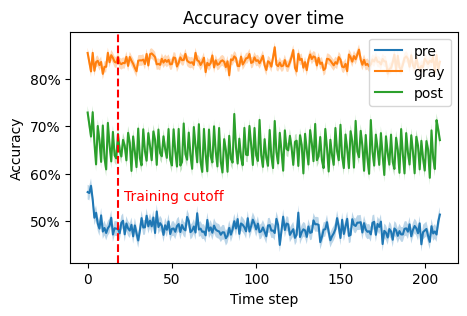

In [36]:
# Plot
plt.figure(figsize=(5, 3))
plt.title("Accuracy over time")
plt.xlabel("Time step")
plt.ylabel("Accuracy")

# Make y-axis percentage
plt.yticks(ticks=[0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], labels=["0%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"])

for phase in ["pre", "gray", "post"]:
    data = grouped[grouped["Image phase"] == phase]
    plt.plot(data["Time index"], data["mean"], label=phase)
    plt.fill_between(data["Time index"], data["lower_95_ci"], data["upper_95_ci"], alpha=0.3)

plt.legend(loc='upper right')

# Draw the line at 18
plt.axvline(x=18, color='r', linestyle='--')
plt.annotate("Training cutoff", (18, 0.5), textcoords="offset points", xytext=(40, 15), ha='center', fontsize=10, color='r')